# Imports 

In [1]:
import tensorflow as tf
import common_functions as hf
from tensorflow import keras 
from tensorflow.keras import layers 
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#Getting dataset from tensorflow dataset

In [2]:
(train_data, test_data), ds_info = tfds.load(name = 'food101', as_supervised = True, 
                                             shuffle_files = True, with_info=True, split=["train","validation"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteBXHZJM/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteBXHZJM/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


# Declaring constants

In [3]:
IMG_SIZE = (256,256)
IMG_HEIGHT = 256 
IMG_WIDTH = 256
NUM_CLASSES = ds_info.features['label'].num_classes
CLASS_NAMES = ds_info.features['label'].names

# Batching and preparing Data set

In [4]:
def preprocess_img(image, label):
  image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
  return tf.cast(image, dtype=tf.float32), label

train_data = train_data.map(map_func = preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=10000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocessing and other baseModels

In [5]:
data_augModel = keras.Sequential([
  layers.RandomFlip(),
  layers.RandomZoom(.2),
  layers.RandomContrast(.2),
  layers.RandomHeight(.2),
  layers.RandomWidth(.2) 
])

efficientnet_model =  keras.applications.EfficientNetB0( include_top = False )

16719872/16705208 [==============================] - 0s 0us/step


# 101 Building Model mix-percision enabled 

In [6]:
keras.mixed_precision.set_global_policy('mixed_float16')

efficientnet_model.trainable = False

inputs = layers.Input( shape = IMG_SIZE + (3,))
x = data_augModel(inputs)
x = efficientnet_model(x)
x = layers.GlobalAveragePooling2D(name = "globalPoolingLayer")(x)
x = layers.Dense(NUM_CLASSES) (x)
outputs = layers.Activation('softmax', dtype='float32') (x)
model = keras.Model(inputs, outputs)

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


# Feature Extrcation


In [8]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = keras.optimizers.Adam(),
              metrics = ['accuracy'])


model_historyFE = model.fit(train_data, epochs = 3, validation_data=test_data, 
                            validation_steps = .15 * len(test_data))

Epoch 1/3
2368/2368 [==============================] - 300s 114ms/step - loss: 2.1911 - accuracy: 0.4739 - val_loss: 1.3139 - val_accuracy: 0.6555
Epoch 2/3
2368/2368 [==============================] - 221s 89ms/step - loss: 1.6908 - accuracy: 0.5709 - val_loss: 1.1870 - val_accuracy: 0.6804
Epoch 3/3
2368/2368 [==============================] - 202s 81ms/step - loss: 1.5682 - accuracy: 0.5990 - val_loss: 1.1437 - val_accuracy: 0.6893


# Evaluating Feature Extrcation model

790/790 [==============================] - 42s 53ms/step - loss: 1.1642 - accuracy: 0.6888


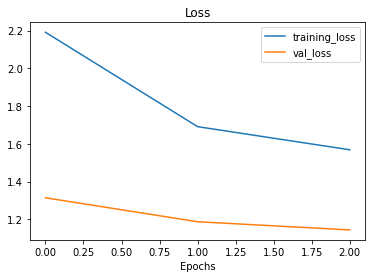

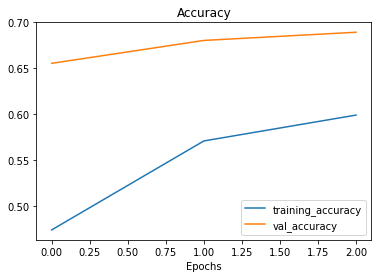

In [9]:
model_evalFE = model.evaluate(test_data)
hf.plot_loss_curves(model_historyFE)

# Training for 3 more epochs

Epoch 3/5
2368/2368 [==============================] - 194s 78ms/step - loss: 1.4888 - accuracy: 0.6143 - val_loss: 1.1182 - val_accuracy: 0.6993
Epoch 4/5
2368/2368 [==============================] - 195s 78ms/step - loss: 1.4435 - accuracy: 0.6279 - val_loss: 1.1023 - val_accuracy: 0.6980
Epoch 5/5
2368/2368 [==============================] - 192s 77ms/step - loss: 1.3987 - accuracy: 0.6373 - val_loss: 1.0898 - val_accuracy: 0.6996


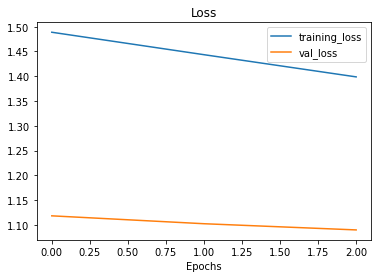

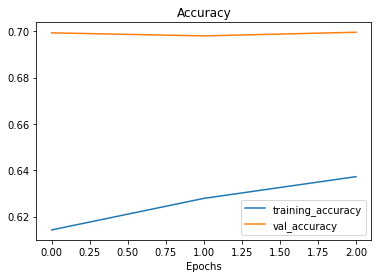

In [10]:
model_historyFE2 = model.fit(train_data, epochs = 5, validation_data=test_data, 
                             validation_steps = .15 * len(test_data),
                             initial_epoch = model_historyFE.epoch[-1])
hf.plot_loss_curves(model_historyFE2)

# Fine Tuning 

In [12]:
efficientnet_model.trainable = True 
for layer in efficientnet_model.layers[:-5]:
  layer.trainable = False
model.layers[4].trainable = False
model.summary()

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = keras.optimizers.Adam(),
              metrics = ['accuracy'])

model_historyFT = model.fit(train_data, epochs = 7, validation_data=test_data, 
                             validation_steps = .15 * len(test_data),
                             initial_epoch = model_historyFE2.epoch[-1])

model.save('FTmodel101.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 globalPoolingLayer (GlobalA  (None, 1280)             0         
 veragePooling2D)                                                
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                             

# Evaluating

790/790 [==============================] - 43s 54ms/step - loss: 0.9474 - accuracy: 0.7390


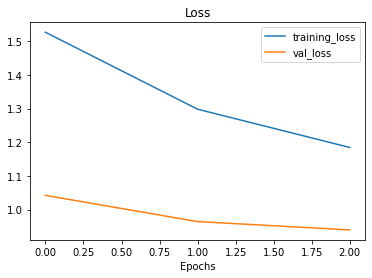

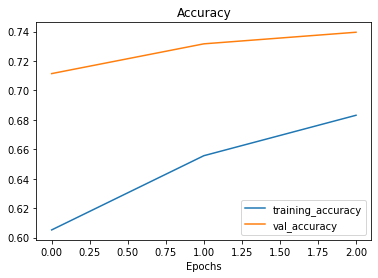

In [13]:
model_evalFE = model.evaluate(test_data)
hf.plot_loss_curves(model_historyFT)